# Определение перспективного тарифа для телеком компании
---

«Мегалайн» — федеральный оператор сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Необходимо сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

### <font color=blue> Описание тарифов </font>
---

#### <font color=purple> Тариф «Смарт» </font>

1. Ежемесячная плата: 550 рублей
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
 - минута разговора: 3 рубля;
 - сообщение: 3 рубля;
 - 1 Гб интернет-трафика: 200 рублей;

#### <font color=purple> Тариф «Ультра» </font>
1. Ежемесячная плата: 1950 рублей
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
 - минута разговора: 1 рубль;
 - сообщение: 1 рубль;
 - 1 Гб интернет-трафика: 150 рублей.

!!! «Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.

## <font color=red> Описание данных </font>
---
#### <font color=green> Таблица users (информация о пользователях): </font>
- user_id — уникальный идентификатор пользователя;
- first_name — имя пользователя;
- last_name — фамилия пользователя;
- age — возраст пользователя (годы);
- reg_date — дата подключения тарифа (день, месяц, год);
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных);
- city — город проживания пользователя;
- tariff — название тарифного плана.

#### <font color=green> Таблица calls (информация о звонках): </font>
- id — уникальный номер звонка;
- call_date — дата звонка;
- duration — длительность звонка в минутах;
- user_id — идентификатор пользователя, сделавшего звонок.

#### <font color=green> Таблица messages (информация о сообщениях): </font>
- id — уникальный номер сообщения;
- message_date — дата сообщения;
- user_id — идентификатор пользователя, отправившего сообщение.

#### <font color=green> Таблица internet (информация об интернет-сессиях): </font>
- id — уникальный номер сессии;
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах);
- session_date — дата интернет-сессии;
- user_id — идентификатор пользователя.

#### <font color=green> Таблица tariffs (информация о тарифах): </font>
- tariff_name — название тарифа;
- rub_monthly_fee — ежемесячная абонентская плата в рублях;
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату;
- messages_included — количество сообщений в месяц, включённых в абонентскую плату;
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах);
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата);
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета;
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта).

### Шаг 1. Загрузка данных

In [1]:
# импортируем данные
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st


In [2]:
# и сохраним исходные таблицы в переменных:

users = pd.read_csv('/datasets/users.csv')
calls = pd.read_csv('/datasets/calls.csv')
messages = pd.read_csv('/datasets/messages.csv')
internet = pd.read_csv('/datasets/internet.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')

Просмотрим информацию по каждой из таблиц:

In [3]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


В таблице представлены данные о 500 пользователях: идентификатор пользователя, возраст, дата отключения от тарифа (есть строки с пропущенными значениями, это говорит о том, что пользователь на дату выгрузки данных пользовался тарифом), город проживания, имя, фамилия пользователя, дата подключения и выбранный пользователем тариф. Столбцы churn_date и reg_date представлены в формате object, в дальнейшем необходимо перевести их в date.

In [4]:
calls

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499
202603,1499_216,2018-10-18,18.83,1499
202604,1499_217,2018-11-10,10.81,1499
202605,1499_218,2018-10-06,4.27,1499


In [5]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


В таблице представлены данные о 202 607 сделанных пользователями звонках: идентификатор звонка, дата совершения звонка, длительность звонка, идентификатор пользователя. Пропущенных значений нет. Длительность звонка необходимо округлить до целого значения в большую сторону. Также в этом столбце есть нулевые значения. Округлим эти значения до 1 минуты. Столбец call_date из типа object необходимо преобразовать в date. 

In [6]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


В таблице представленные данные о 123 036 отправленных пользователями сообщениях: идентификатор сообщения, дата сообщения, идентификатор пользователя. Столбец message_date из типа object необходимо преобразовать в date. 

In [7]:
internet

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
...,...,...,...,...,...
149391,149391,1499_152,318.90,2018-10-03,1499
149392,149392,1499_153,490.13,2018-12-14,1499
149393,149393,1499_154,0.00,2018-10-27,1499
149394,149394,1499_155,1246.32,2018-11-26,1499


In [8]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


В таблице представлены данные о 149 396 совершенных пользователями интернет-сессиях: идентификатор сессии, количество потраченных мегабайтов, дата сессии, идентификатор пользователя. Пропущенных значений нет. Количество потраченных мегабайт необходимо округлить до целого значения в большую сторону. Также в этом столбце есть нулевые значения. Округлим эти значения до 1 Мб. Столбец session_date из типа object необходимо преобразовать в date. 

In [9]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


В таблице представлена справочная информация о двух, предлагаемых "Мегалайном" тарифах: их названия, количество включенных в абонентскую плату сообщениях, мегабайтах, минутах, о сумме абонентской платы, и стоимость дополнительных 1 сообщения, 1 Гб и 1 минуты. Пропущенных значений нет, проблем в типах данных нет.

### Шаг 2. Предобработка данных
#### Обработка пропусков

Пропущенных значений в таблицах нет, но есть нулевые. Рассмотрим их и наличие других нестандартных значений.

##### Таблица users

In [10]:
users.loc[users['user_id'] > 1499]

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff


In [11]:
users.loc[users['user_id'] < 1000]

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff


In [12]:
# проверим дубликаты идентификаторов пользователей:

users['user_id'].duplicated().sum()

0

В таблице users в столбце user_id нет значений меньше 1000 и больше 1499, т.е. данные о идентификаторе пользователя заполнены корректно, дубликатов нет.

In [13]:
users.loc[users['age'] > 100]

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff


In [14]:
users.loc[users['age'] < 18]

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff


В таблице users в столбце age нет значений меньше 18 и больше 100, т.е. данные о возрасте пользователя заполнены корректно.

In [15]:
# проверим столбец tariff:
users['tariff'].unique() 

array(['ultra', 'smart'], dtype=object)

Столбец tariff заполнен корректно

##### Таблица calls

In [16]:
# количество строк, в которых нулевая длительность звонка:
calls.loc[calls['duration'] == 0, 'duration'].value_counts()

0.0    39613
Name: duration, dtype: int64

In [17]:
# заменим нулевые значения в столбце с длительностью звонка на 1:
calls.loc[calls['duration'] == 0, 'duration'] = 1

In [18]:
# округлим оставшиеся значения до целого в большую сторону:
calls['duration'] = calls['duration'].apply(np.ceil)

In [19]:
calls.loc[calls['user_id'] > 1499]

,id,call_date,duration,user_id


In [20]:
calls.loc[calls['user_id'] < 1000]

,id,call_date,duration,user_id


В таблице calls в столбце user_id нет значений меньше 1000 и больше 1499, т.е. данные о идентификаторе пользователя заполнены корректно.

##### Таблица internet

In [21]:
# заменим нулевые значения в столбце с количеством потраченных мегабайт на 1:
internet.loc[internet['mb_used'] == 0, 'mb_used'] = 1

In [22]:
# округлим оставшиеся значения до целого в большую сторону:
internet['mb_used'] = internet['mb_used'].apply(np.ceil)

In [23]:
internet.loc[internet['user_id'] > 1499]

,Unnamed: 0,id,mb_used,session_date,user_id


In [24]:
internet.loc[internet['user_id'] < 1000]

,Unnamed: 0,id,mb_used,session_date,user_id


In [25]:
# удалим столбец Unnamed: 0
internet.drop('Unnamed: 0', axis=1, inplace=True) 

In [26]:
internet

,id,mb_used,session_date,user_id
0,1000_0,113.0,2018-11-25,1000
1,1000_1,1053.0,2018-09-07,1000
2,1000_2,1198.0,2018-06-25,1000
3,1000_3,551.0,2018-08-22,1000
4,1000_4,303.0,2018-09-24,1000
...,...,...,...,...
149391,1499_152,319.0,2018-10-03,1499
149392,1499_153,491.0,2018-12-14,1499
149393,1499_154,1.0,2018-10-27,1499
149394,1499_155,1247.0,2018-11-26,1499


#### Замена типа данных

In [27]:
# преобразуем тип данных в столбце churn_date таблицы users в datetime64:
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')

In [28]:
# преобразуем тип данных в столбце churn_date таблицы users в datetime64:
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

In [29]:
# преобразуем тип данных в столбце call_date таблицы calls в datetime64:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')

In [30]:
# преобразуем тип данных в столбце message_date таблицы messages в datetime64:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')

In [31]:
# преобразуем тип данных в столбце session_date таблицы internet в datetime64:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

#### Обработка дубликатов

In [32]:
# посчитаем дублирующие строки в каждой из таблиц
for data in [users, calls, messages, internet, tariffs]: 
    print(data.duplicated().sum(), end='\n\n')

0

0

0

0

0



Дубликатов нет

#### Посчитаем для каждого пользователя:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя.

In [33]:
# добавим столбец с номером месяца в таблицах calls, messages, internet:
calls['month'] = calls['call_date'].dt.month
messages['month'] = messages['message_date'].dt.month
internet['month'] = internet['session_date'].dt.month

##### Количество сделанных звонков и израсходованных минут разговора по месяцам

In [34]:
# построим сводную таблицу, в которой по идентификатору пользователя по каждому месяцу посчитаем количество звонков и сумму
# израсходованных минут
pivot_calls = calls.pivot_table(index=['user_id', 'month'], values = 'duration', aggfunc=['count', 'sum'])

# заменим названия столбцов:
pivot_calls.columns = ['number_of_calls', 'sum_minutes']
pivot_calls

number_of_calls  sum_minutes
user_id month                              
1000    5                   22        164.0
        6                   43        187.0
        7                   47        346.0
        8                   52        418.0
        9                   58        478.0
...                        ...          ...
1498    10                  41        258.0
1499    9                    9         71.0
        10                  68        473.0
        11                  74        624.0
        12                  69        505.0

[3174 rows x 2 columns]

##### Количество отправленных сообщений по месяцам

In [35]:
# построим сводную таблицу, в которой по идентификатору пользователя по каждому месяцу посчитаем количество сообщений:
pivot_messages = messages.pivot_table(index=['user_id', 'month'], values = 'id', aggfunc='count')

# заменим названия столбцов:
pivot_messages.columns = ['number_of_messages']
pivot_messages

number_of_messages
user_id month                    
1000    5                      22
        6                      60
        7                      75
        8                      81
        9                      57
...                           ...
1498    10                     42
1499    9                      11
        10                     48
        11                     59
        12                     66

[2717 rows x 1 columns]

##### Объем израсходованного интернет-трафика по месяцам

In [36]:
# построим сводную таблицу, в которой по идентификатору пользователя по каждому месяцу посчитаем количество сообщений:
pivot_internet = internet.pivot_table(index=['user_id', 'month'], values = 'mb_used', aggfunc='sum')

# заменим названия столбцов:
pivot_internet.columns = ['sum_mb_used']
pivot_internet

sum_mb_used
user_id month             
1000    5           2257.0
        6          23262.0
        7          14017.0
        8          14072.0
        9          14583.0
...                    ...
1498    10         20614.0
1499    9           1849.0
        10         17824.0
        11         17994.0
        12         13082.0

[3203 rows x 1 columns]

##### Помесячная выручка с каждого пользователя

In [37]:
# объединим таблицы pivot_calls, pivot_messages, pivot_internet:
# сначала объединим таблицу звонков и сообщений
pivot_calls_messages = pivot_calls.join(pivot_messages, how='outer')

# затем полученную таблицу присоединим к таблице с данными о интернете
pivot_calls_messages_internet = pivot_internet.join(pivot_calls_messages, how='outer')
pivot_calls_messages_internet

sum_mb_used  number_of_calls  sum_minutes  number_of_messages
user_id month                                                               
1000    5           2257.0             22.0        164.0                22.0
        6          23262.0             43.0        187.0                60.0
        7          14017.0             47.0        346.0                75.0
        8          14072.0             52.0        418.0                81.0
        9          14583.0             58.0        478.0                57.0
...                    ...              ...          ...                 ...
1498    10         20614.0             41.0        258.0                42.0
1499    9           1849.0              9.0         71.0                11.0
        10         17824.0             68.0        473.0                48.0
        11         17994.0             74.0        624.0                59.0
        12         13082.0             69.0        505.0                66.0

[3214 rows x 4 columns]

In [38]:
pivot_calls_messages_internet.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3214 entries, (1000, 5) to (1499, 12)
Data columns (total 4 columns):
sum_mb_used           3203 non-null float64
number_of_calls       3174 non-null float64
sum_minutes           3174 non-null float64
number_of_messages    2717 non-null float64
dtypes: float64(4)
memory usage: 114.0 KB


Заполним отсутствующие значения в полученной таблице нулями:

In [39]:
pivot_calls_messages_internet.loc[pivot_calls_messages_internet['sum_mb_used'].isna(), 'sum_mb_used'] = 0
pivot_calls_messages_internet.loc[pivot_calls_messages_internet['number_of_calls'].isna(), 'number_of_calls'] = 0
pivot_calls_messages_internet.loc[pivot_calls_messages_internet['sum_minutes'].isna(), 'sum_minutes'] = 0
pivot_calls_messages_internet.loc[pivot_calls_messages_internet['number_of_messages'].isna(), 'number_of_messages'] = 0
pivot_calls_messages_internet.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3214 entries, (1000, 5) to (1499, 12)
Data columns (total 4 columns):
sum_mb_used           3214 non-null float64
number_of_calls       3214 non-null float64
sum_minutes           3214 non-null float64
number_of_messages    3214 non-null float64
dtypes: float64(4)
memory usage: 274.0 KB


In [40]:
# добавим название тарифа для каждого пользователя в таблицу pivot_calls_messages_internet из таблицы users:
for user in pivot_calls_messages_internet.index:
    pivot_calls_messages_internet.loc[user, 'tariff'] = users.loc[user[0]-1000, 'tariff']

pivot_calls_messages_internet

sum_mb_used  number_of_calls  sum_minutes  number_of_messages  \
user_id month                                                                  
1000    5           2257.0             22.0        164.0                22.0   
        6          23262.0             43.0        187.0                60.0   
        7          14017.0             47.0        346.0                75.0   
        8          14072.0             52.0        418.0                81.0   
        9          14583.0             58.0        478.0                57.0   
...                    ...              ...          ...                 ...   
1498    10         20614.0             41.0        258.0                42.0   
1499    9           1849.0              9.0         71.0                11.0   
        10         17824.0             68.0        473.0                48.0   
        11         17994.0             74.0        624.0                59.0   
        12         13082.0             69.0        505.0                66.0   

              tariff  
user_id month         
1000    5      ultra  
        6      ultra  
        7      ultra  
        8      ultra  
        9      ultra  
...              ...  
1498    10     smart  
1499    9      smart  
        10     smart  
        11     smart  
        12     smart  

[3214 rows x 5 columns]

In [41]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [42]:
# посчитаем количество потраченных сверх тарифного плана мегабайт 
def calc_mb_over(row):
    tariff = row['tariff']
    sum_mb_used = row['sum_mb_used']
    if tariff == 'smart':
        return (sum_mb_used - tariffs.loc[0, 'mb_per_month_included'])
    else:
        return (sum_mb_used - tariffs.loc[1, 'mb_per_month_included'])

# создадим новый столбец с количеством потраченных сверх тарифного плана мегабайт
pivot_calls_messages_internet['mb_over'] = pivot_calls_messages_internet.apply(calc_mb_over, axis=1)

# заменим отрицательные значения в полученном столбце на 0:
pivot_calls_messages_internet.loc[pivot_calls_messages_internet['mb_over'] < 0, 'mb_over'] = 0

In [43]:
# посчитаем количество потраченных сверх тарифного плана минут
def calc_minutes_over(row):
    tariff = row['tariff']
    sum_minutes = row['sum_minutes']
    if tariff == 'smart':
        return (sum_minutes - tariffs.loc[0, 'minutes_included'])
    else:
        return (sum_minutes - tariffs.loc[1, 'minutes_included'])

# создадим новый столбец с количеством потраченных сверх тарифного плана минут
pivot_calls_messages_internet['minutes_over'] = pivot_calls_messages_internet.apply(calc_minutes_over, axis=1)

# заменим отрицательные значения в полученном столбце на 0:
pivot_calls_messages_internet.loc[pivot_calls_messages_internet['minutes_over'] < 0, 'minutes_over'] = 0

In [44]:
# посчитаем количество потраченных сверх тарифного плана сообщений
def calc_messages_over(row):
    tariff = row['tariff']
    number_of_messages = row['number_of_messages']
    if tariff == 'smart':
        return (number_of_messages - tariffs.loc[0, 'messages_included'])
    else:
        return (number_of_messages - tariffs.loc[1, 'messages_included'])

# создадим новый столбец с количеством потраченных сверх тарифного плана сообщений
pivot_calls_messages_internet['messages_over'] = pivot_calls_messages_internet.apply(calc_messages_over, axis=1)

# заменим отрицательные значения в полученном столбце на 0:
pivot_calls_messages_internet.loc[pivot_calls_messages_internet['messages_over'] < 0, 'messages_over'] = 0

In [45]:
# посчитаем выручку, для этого количество минут, сообщений и мегабайт, потраченных сверх тарифного плана, умножим на значение
# из тарифного плана, и прибавим абонентскую плату, соответствующую тарифному плану:
def calc_revenue(row):
    tariff = row['tariff']
    minutes_over = row['minutes_over']
    messages_over = row['messages_over']
    mb_over = row['mb_over']
    if tariff == 'smart':
        return (tariffs.loc[0, 'rub_monthly_fee'] + minutes_over * tariffs.loc[0, 'rub_per_minute'] +
                messages_over * tariffs.loc[0, 'rub_per_message'] + (mb_over / 1024) * tariffs.loc[0, 'rub_per_gb'])
    else:
        return (tariffs.loc[1, 'rub_monthly_fee'] + minutes_over * tariffs.loc[1, 'rub_per_minute'] +
                messages_over * tariffs.loc[1, 'rub_per_message'] + (mb_over / 1024) * tariffs.loc[1, 'rub_per_gb'])
                                                                               
                                                                               
# создадим новый столбец со значением выручки по каждому пользователю за каждый месяц:
pivot_calls_messages_internet['revenue'] = pivot_calls_messages_internet.apply(calc_revenue, axis=1)
pivot_calls_messages_internet

sum_mb_used  number_of_calls  sum_minutes  number_of_messages  \
user_id month                                                                  
1000    5           2257.0             22.0        164.0                22.0   
        6          23262.0             43.0        187.0                60.0   
        7          14017.0             47.0        346.0                75.0   
        8          14072.0             52.0        418.0                81.0   
        9          14583.0             58.0        478.0                57.0   
...                    ...              ...          ...                 ...   
1498    10         20614.0             41.0        258.0                42.0   
1499    9           1849.0              9.0         71.0                11.0   
        10         17824.0             68.0        473.0                48.0   
        11         17994.0             74.0        624.0                59.0   
        12         13082.0             69.0        505.0                66.0   

              tariff  mb_over  minutes_over  messages_over      revenue  
user_id month                                                            
1000    5      ultra      0.0           0.0            0.0  1950.000000  
        6      ultra      0.0           0.0            0.0  1950.000000  
        7      ultra      0.0           0.0            0.0  1950.000000  
        8      ultra      0.0           0.0            0.0  1950.000000  
        9      ultra      0.0           0.0            0.0  1950.000000  
...              ...      ...           ...            ...          ...  
1498    10     smart   5254.0           0.0            0.0  1576.171875  
1499    9      smart      0.0           0.0            0.0   550.000000  
        10     smart   2464.0           0.0            0.0  1031.250000  
        11     smart   2634.0         124.0            9.0  1463.453125  
        12     smart      0.0           5.0           16.0   613.000000  

[3214 rows x 9 columns]

### Шаг 3. Проанализируйте данные

Посчитаем сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц

In [46]:
pivot_calls_messages_internet.pivot_table(
    index='tariff', values=['sum_minutes', 'number_of_messages', 'sum_mb_used'], aggfunc='median')

,number_of_messages,sum_mb_used,sum_minutes
tariff,,,
smart,28.0,16540.0,435.0
ultra,38.0,19324.0,532.0


Клиенты с тарифом "Ультра" в среднем отправляют больше сообщений, тратят больше минут на разговоры и используют больше интернет-трафика.

Посчитаем среднее количество, дисперсию и стандартное отклонение.

In [47]:
pivot_calls_messages_internet.pivot_table(
    index=['tariff'], values=['sum_minutes', 'number_of_messages', 'sum_mb_used'], 
                    aggfunc={'sum_minutes': [np.median, np.var, np.std], 
                             'number_of_messages': [np.median, np.var, np.std], 
                             'sum_mb_used': [np.median, np.var, np.std]})

number_of_messages                         sum_mb_used                \
                   median        std          var      median           std   
tariff                                                                        
smart                28.0  28.227876   796.812958     16540.0   5879.795158   
ultra                38.0  47.804457  2285.266143     19324.0  10097.107541   

                     sum_minutes                             
                 var      median         std            var  
tariff                                                       
smart   3.457199e+07       435.0  194.871174   37974.774628  
ultra   1.019516e+08       532.0  325.738740  106105.726823

Построим гистограммы

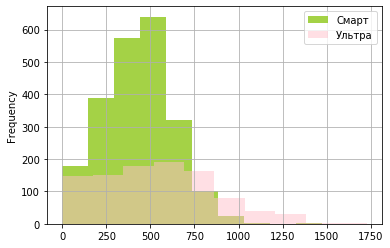

In [48]:
ax = pivot_calls_messages_internet.query('tariff == "smart"')['sum_minutes'].plot(kind='hist', alpha=0.9, label='Смарт', legend=True, color='yellowgreen')
pivot_calls_messages_internet.query('tariff == "ultra"')['sum_minutes'].plot(kind='hist', alpha=0.5, label='Ультра', ax=ax, grid=True, legend=True, color='pink')

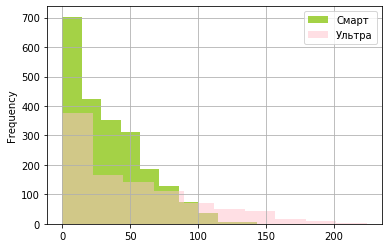

In [49]:
ax = pivot_calls_messages_internet.query('tariff == "smart"')['number_of_messages'].plot(kind='hist', alpha=0.9, label='Смарт', legend=True, color='yellowgreen')
pivot_calls_messages_internet.query('tariff == "ultra"')['number_of_messages'].plot(kind='hist', alpha=0.5, label='Ультра', ax=ax, grid=True, legend=True, color='pink')

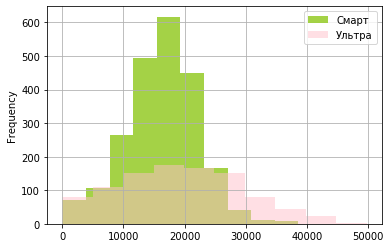

In [50]:
ax = pivot_calls_messages_internet.query('tariff == "smart"')['sum_mb_used'].plot(kind='hist', alpha=0.9, label='Смарт', legend=True, color='yellowgreen')
pivot_calls_messages_internet.query('tariff == "ultra"')['sum_mb_used'].plot(kind='hist', alpha=0.5, label='Ультра', ax=ax, grid=True, legend=True, color='pink')

Пользователи тарифа "Ультра" более активно и разнообразно пользуются услугами оператора сотовой связи.

### Шаг 4. Проверьте гипотезы

##### - средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;

Нулевая гипотеза:
 H0  — средняя выручка пользователей тарифа «Ультра» равна средней выручке пользователей тарифа «Смарт»;

альтернативная гипотеза:
 H1 — средняя выручка пользователей тарифов «Ультра» не равна средней выручке пользователей тарифа «Смарт».

Уровень значимости возьмем 0.05, если p-value окажется меньше него - отвергнем нулевую гипотезу.

Чтобы проверить гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам, применяется метод scipy.stats.ttest_ind

In [51]:
alpha = 0.05

results = st.ttest_ind(
    pivot_calls_messages_internet.query('tariff == "smart"')['revenue'], 
    pivot_calls_messages_internet.query('tariff == "ultra"')['revenue'], equal_var = False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 2.453574440087548e-281
Отвергаем нулевую гипотезу


С вероятностью очень близкой к 1 можно сказать, что средняя выручка пользователей тарифа "Ультра" не равна средней выручке пользователей тарифа "Смарт"

#### - средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;

In [52]:
# добавим в таблицу pivot_calls_messages_internet город проживания пользователя из таблицы users:

for user in pivot_calls_messages_internet.index:
    pivot_calls_messages_internet.loc[user, 'city'] = users.loc[user[0]-1000, 'city']

Нулевая гипотеза:
 H0  — средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов;

альтернативная гипотеза:
 H1 — средняя выручка пользователей из Москвы не равна средней выручке пользователей из других регионов.

Уровень значимости возьмем 0.05, если p-value окажется меньше него - отвергнем нулевую гипотезу.

In [53]:
alpha = 0.05
results = st.ttest_ind(
    pivot_calls_messages_internet.query('city == "Москва"')['revenue'], 
    pivot_calls_messages_internet.query('tariff != "Москва"')['revenue'], equal_var = False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5788058121369999
Не получилось отвергнуть нулевую гипотезу


In [54]:
print('Средняя выручка по Москве', pivot_calls_messages_internet.query('city == "Москва"')['revenue'].median())

Средняя выручка по Москве 1733.59375


In [55]:
print('Средняя выручка в регионах', pivot_calls_messages_internet.query('city != "Москва"')['revenue'].median())

Средняя выручка в регионах 1545.8984375


Средняя выручка в Москве несильно отличается от выручки пользователей в других регионах.

### Шаг 5. Общий вывод

In [56]:
# посчитаем сумму, которую доплачивает пользователь сверх абонентской платы, для этого из общей выручки вычтем сумму абонентской
# платы:
def rub_monthly_fee_over(row):
    tariff = row['tariff']
    revenue = row['revenue']
    
    if tariff == 'smart':
        return (revenue - tariffs.loc[0, 'rub_monthly_fee'])
    else:
        return (revenue - tariffs.loc[1, 'rub_monthly_fee'])
                                                                               
                                                                               
# создадим новый столбец c суммой доплаты сверх абонентской платы:
pivot_calls_messages_internet['rub_monthly_fee_over'] = pivot_calls_messages_internet.apply(rub_monthly_fee_over, axis=1)

In [57]:
pivot_calls_messages_internet.pivot_table(
    index='tariff', values=['minutes_over', 'messages_over', 'mb_over', 'rub_monthly_fee_over'], aggfunc='median')

,mb_over,messages_over,minutes_over,rub_monthly_fee_over
tariff,,,,
smart,1180.0,0.0,0.0,437.664062
ultra,0.0,0.0,0.0,0.000000


Как видно из таблицы, средний пользователь тарифа "Смарт" доплачивает примерно 440 руб. сверх абонентской платы, в то время как пользователи тарифа "Ультра" пользуются услугами оператора в рамках предоставленных пакетов, включенных в абонентскую плату.

In [58]:
pivot_calls_messages_internet.pivot_table(
    index='tariff', values='revenue', aggfunc={'revenue': ['count', 'sum', 'median']})

,count,median,sum
tariff,,,
smart,2229,987.664062,2.789392e+06
ultra,985,1950.000000,2.029683e+06


Рекламный бюджет нужно направить на привлечение внимания пользователей к тарифу "Ультра", например, акцентируя внимание в рекламе на бОльшее количество интернет-трафика, включенного в абонентскую плату.